# Investigation of different voltage levels on the Transmission Capacity using Italy and Germany as a case study

This notebooks aims to investigate transmission capacity lines in `base.nc` from PyPSA-Earth workflow to improve accuracy of power flow modeling based on the conversation from [here](https://github.com/pypsa-meets-earth/documentation/pull/68). In another analysis done [here](https://github.com/pypsa-meets-earth/documentation/blob/main/notebooks/validation/osm_validation_using_at_and_mk.ipynb), it is observed that there might be some inconsistencies when translating power grid data from OSM-extracted dataset `base.csv` to parameters of the power flow model `base.nc`.

For this analysis, Italy and Germany were chosen to be used as a case study to reveal a reason behind the high discrepancy in terms of line capacity between OSM-extracted data and ENTSOE data, as has been detected [here](https://github.com/pypsa-meets-earth/documentation/pull/68).

### Loading Libraries

In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt

import warnings

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 1000)

/Users/gbotemi/miniconda3/envs/pypsa-earth-updated/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning: The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 
  warnings.warn(


### Loading data files

This notebook uses a prepared `base.nc` network model which should be loaded manually from [here](https://drive.google.com/drive/folders/18dV790r11hHKIwpbyDBaxMV4XbhBFQde?usp=drive_link). After extraction, the files will be into subfolder of the current working folder "osm_data_validation_AT_MK_IT_DE"

In [2]:
# There is a need to extract current (i_nom) of line_types that are used in pypsa-earth for rebasing from pypsa network
n = pypsa.Network()

In [3]:
# A clean entsoe network will be needed for the analysis
# Download the network from here: https://drive.google.com/file/d/16DHvFbNah9LblbXOjIbZ6H0cHmCaYH_U/view?usp=drive_link
entsoe_nc = pypsa.Network("elec.nc")

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, links, loads, storage_units, transformers


In [4]:
# Raw entsoe data is also needed, but needs to undergo preprocessing

# Download raw entsoe data. Uncomment the next line to download the file
# !wget "https://github.com/PyPSA/pypsa-eur/raw/master/data/entsoegridkit/lines.csv" -O "entsoe_lines_ref.csv"

# Load entsoe line.csv with pandas dataframe
entsoe_ref_csv = pd.read_csv("entsoe_lines_ref.csv", delimiter=",", quotechar="'")

# Apply well known text(wkt) to format the geometry column properly
entsoe_ref_csv["geometry"] = entsoe_ref_csv.geometry.apply(wkt.loads)

# Load the data into a geopandas dataframe and format it using a compatible crs
entsoe_csv = gpd.GeoDataFrame(entsoe_ref_csv, geometry="geometry", crs="EPSG:3035")

# Convert voltage from kV to V
entsoe_csv["voltage"] = entsoe_csv.voltage * 1000

In [5]:
# Networks paths
de_base_nc_file = f"osm_data_validation_AT_MK_IT_DE/networks/DE/base.nc"
it_base_nc_file = f"osm_data_validation_AT_MK_IT_DE/networks/IT/base.nc"

# Resource files paths
de_base_csv_file = f"osm_data_validation_AT_MK_IT_DE/resources/DE/base_network/all_lines_build_network.csv"
it_base_csv_file = f"osm_data_validation_AT_MK_IT_DE/resources/IT/base_network/all_lines_build_network.csv"

de_country_shape_file = (
    f"osm_data_validation_AT_MK_IT_DE/resources/DE/shapes/country_shapes.geojson"
)
it_country_shape_file = (
    f"osm_data_validation_AT_MK_IT_DE/resources/IT/shapes/country_shapes.geojson"
)

In [6]:
# Loading network files
de_base_nc = pypsa.Network(de_base_nc_file)
it_base_nc = pypsa.Network(it_base_nc_file)

# Loading base csv file for IT and DE.
# Geometry length in osm_data needs to be reporojected to the same projection as entsoe data
de_base_csv = pd.read_csv(de_base_csv_file)
de_base_csv["geometry"] = de_base_csv.geometry.apply(wkt.loads)
de_base_csv = gpd.GeoDataFrame(de_base_csv, geometry="geometry", crs="EPSG:4326")
de_base_csv["reprojected_length"] = de_base_csv.to_crs("EPSG:3035").length

it_base_csv = pd.read_csv(it_base_csv_file)
it_base_csv["geometry"] = it_base_csv.geometry.apply(wkt.loads)
it_base_csv = gpd.GeoDataFrame(it_base_csv, geometry="geometry", crs="EPSG:4326")
it_base_csv["reprojected_length"] = it_base_csv.to_crs("EPSG:3035").length

INFO:pypsa.io:Imported network base.nc has buses, lines, links, transformers
INFO:pypsa.io:Imported network base.nc has buses, lines, links, transformers


In [7]:
# Country shape files will be used as a filter in entsoe data

de_country_shape = gpd.read_file(de_country_shape_file)
it_country_shape = gpd.read_file(it_country_shape_file)

### Functions

In [8]:
def get_i_nom_by_voltage(
    voltage_value: int, voltage_dict: dict, network: pypsa.Network
) -> int:
    """
    Function returns the current corresponding to the voltage_value using line_types in pypsa network
    """

    line_type = max(voltage_dict.values())

    for idx in sorted(voltage_dict.keys()):
        if (voltage_value) <= idx:
            line_type = voltage_dict.get(idx)
            break

    return network.line_types.loc[line_type, "i_nom"]


def calculate_s_nom(
    df: gpd.GeoDataFrame, voltage_dict: dict, network: pypsa.Network
) -> gpd.GeoDataFrame:
    """
    Function calculates the limit of the apparent power (s_nom) using the given formula defined from pypsa earth
    https://github.com/pypsa-meets-earth/pypsa-earth/blob/main/scripts/base_network.py#L353-L363
    s_nom(MVA) = sqrt(3) * v_nom(kV) * circuits * i_nom(kA)
    """

    df["voltage_kV"] = df["voltage"] / 1e3  # convert voltage to kV
    df["s_nom"] = (
        (df["voltage"].apply(lambda row: get_i_nom_by_voltage(row, voltage_dict, n)))
        * df["voltage_kV"]
        * np.sqrt(3)
        * df["circuits"]
    )

    return df

### Reproducing PyPSA Earth Workflow with Base csv file

This section aims to reproduce the pypsa-earth workflow(base.nc) with osm-base-csv

In [9]:
# Accounting for voltage lower than 110kV
u_low = 110

In [10]:
# Dictionary storing standard line types used in pypsa-earth workflow
voltage_dict = {
    u_low: "243-AL1/39-ST1A 110.0",
    220: "Al/St 240/40 2-bundle 220.0",
    300: "Al/St 240/40 3-bundle 300.0",
    380: "Al/St 240/40 4-bundle 380.0",
}

In [11]:
# Calculate s_nom values
de_base_csv_s_nom = calculate_s_nom(de_base_csv, voltage_dict, network=n)
it_base_csv_s_nom = calculate_s_nom(it_base_csv, voltage_dict, network=n)

In [12]:
# Get the sum total for s_nom in base_csv and base_nc
sum_de_base_csv_snom = de_base_csv_s_nom.s_nom.sum()
sum_de_base_nc_snom = de_base_nc.lines.s_nom.sum()

sum_it_base_csv_snom = it_base_csv_s_nom.s_nom.sum()
sum_it_base_nc_snom = it_base_nc.lines.s_nom.sum()

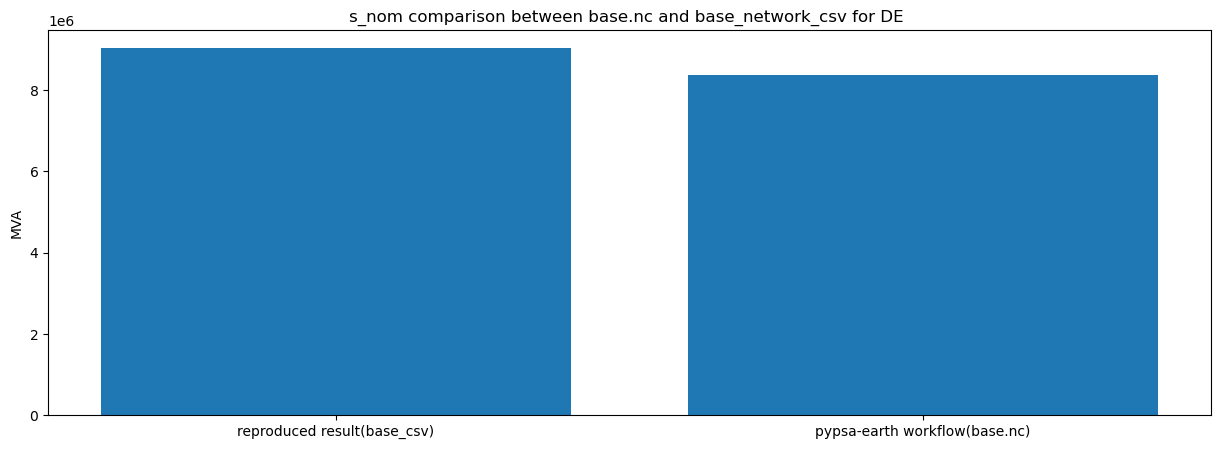

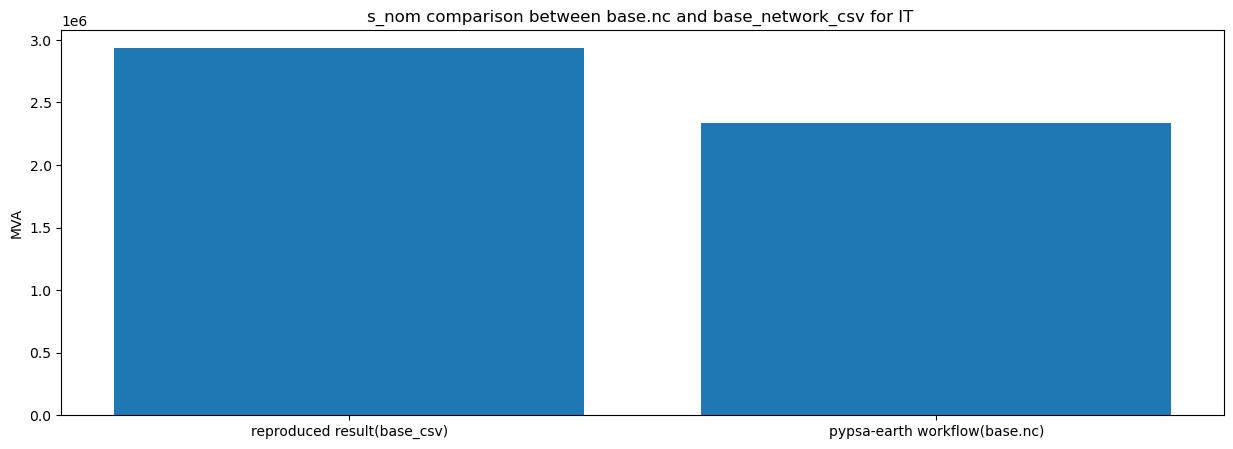

In [13]:
# Plots comparison for reproduced workflow vs pypsa-earth workflow

plt.figure(figsize=(15, 5))
plt.bar(
    ["reproduced result(base_csv)", "pypsa-earth workflow(base.nc)"],
    [sum_de_base_csv_snom, sum_de_base_nc_snom],
)
plt.title(f"s_nom comparison between base.nc and base_network_csv for DE ")
plt.ylabel("MVA")

plt.figure(figsize=(15, 5))
plt.bar(
    ["reproduced result(base_csv)", "pypsa-earth workflow(base.nc)"],
    [sum_it_base_csv_snom, sum_it_base_nc_snom],
)
plt.title(f"s_nom comparison between base.nc and base_network_csv for IT ")
plt.ylabel("MVA")
plt.show()

Checking the difference between entsoe.nc(preprocessed) and entsoe.csv(raw)

In [14]:
entsoe_nc.lines.v_nom.value_counts()

v_nom
220    3408
380    2887
300     397
Name: count, dtype: int64

In [15]:
entsoe_csv.voltage.value_counts()

voltage
220000    5812
380000    3595
300000     831
132000     633
500000     234
750000      46
Name: count, dtype: int64

In [16]:
# Creating a new column to easily identify DE and IT in entsoe_csv
entsoe_csv[f"if_de"] = entsoe_csv["geometry"].apply(
    lambda row: row.within(de_country_shape["geometry"][0])
)
entsoe_csv[f"if_it"] = entsoe_csv["geometry"].apply(
    lambda row: row.within(it_country_shape["geometry"][0])
)

In [17]:
# Merge country data in bus into entsoe_nc lines
entsoe_nc_country = entsoe_nc.lines.merge(
    entsoe_nc.buses["country"].reset_index(), how="left", left_on="bus0", right_on="Bus"
)

In [18]:
# Filtering for country data in entsoe_nc
entsoe_nc_filtered_de = entsoe_nc_country[entsoe_nc_country.country == "DE"]
entsoe_nc_filtered_it = entsoe_nc_country[entsoe_nc_country.country == "IT"]

### Capacity Analysis for Germany and Italy

In [19]:
# Set voltage filterring threshold in V
voltage_threshold = 200000

In [20]:
# Voltage levels in updated base_csv
print("Voltage levels for DE")
print(np.sort(de_base_csv_s_nom.voltage.unique()))
print("Voltage levels for IT")
print(np.sort(it_base_csv_s_nom.voltage.unique()))

Voltage levels for DE
[ 60000  63000  65000 110000 150000 155000 220000 225000 300000 320000
 380000 400000 525000 600000]
Voltage levels for IT
[ 60000  66000  70000 110000 120000 130000 132000 135000 150000 200000
 220000 225000 320000 380000 400000 500000]


Voltages present in the osm_files starts from 60kV because the threshold in the meta data is set to 51kV.

#### s_nom

In [21]:
# Get sum total for s_nom for records above the set threshold

sum_de_base_csv_snom_200kv = de_base_csv_s_nom[
    de_base_csv_s_nom.voltage > voltage_threshold
].s_nom.sum()
sum_it_base_csv_snom_200kv = it_base_csv_s_nom[
    it_base_csv_s_nom.voltage > voltage_threshold
].s_nom.sum()

entsoe_s_nom = calculate_s_nom(
    entsoe_csv[entsoe_csv.voltage >= voltage_threshold], voltage_dict, n
)
sum_de_entsoe_snom = entsoe_s_nom[entsoe_s_nom[f"if_de"] == True].s_nom.sum()
sum_it_entsoe_snom = entsoe_s_nom[entsoe_s_nom[f"if_it"] == True].s_nom.sum()

sum_entose_nc_de_snom = entsoe_nc_filtered_de.s_nom.sum()
sum_entose_nc_it_snom = entsoe_nc_filtered_it.s_nom.sum()

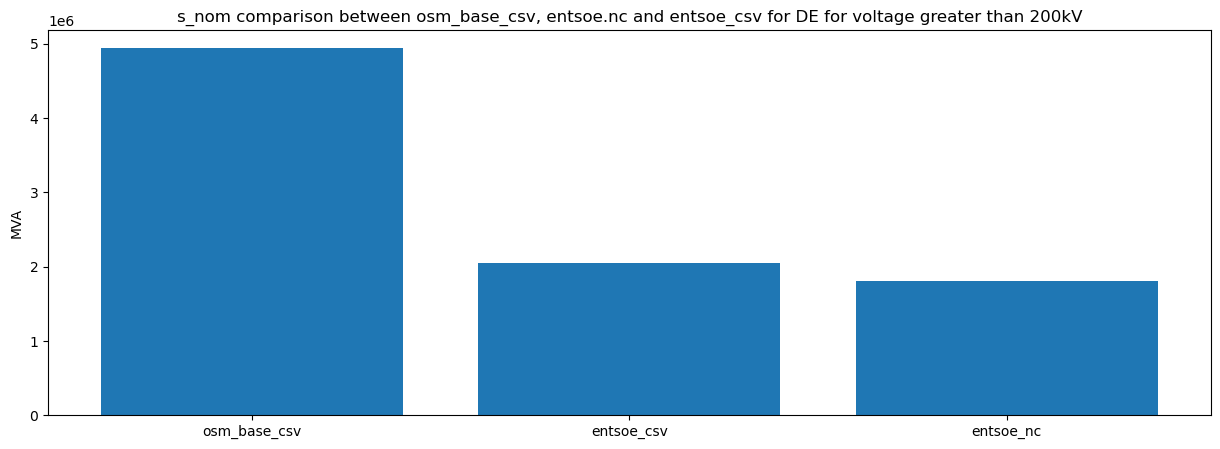

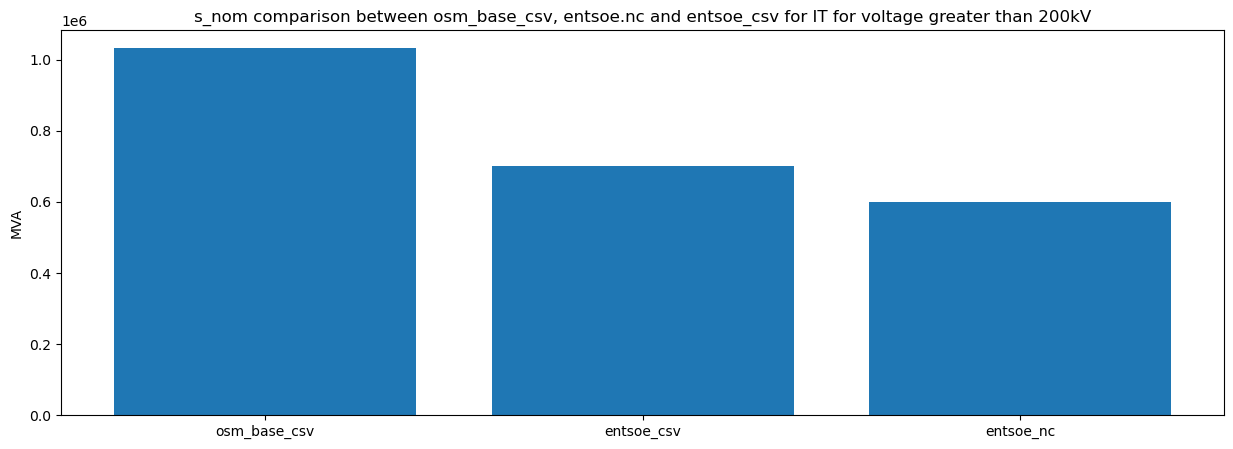

In [22]:
# Plots comparison for s_nom between osm_base_network_csv, entsoe_csv and entsoe_nc

plt.figure(figsize=(15, 5))
plt.bar(
    ["osm_base_csv", "entsoe_csv", "entsoe_nc"],
    [sum_de_base_csv_snom_200kv, sum_de_entsoe_snom, sum_entose_nc_de_snom],
)
plt.title(
    f"s_nom comparison between osm_base_csv, entsoe.nc and entsoe_csv for DE for voltage greater than 200kV"
)
plt.ylabel("MVA")

plt.figure(figsize=(15, 5))
plt.bar(
    ["osm_base_csv", "entsoe_csv", "entsoe_nc"],
    [sum_it_base_csv_snom_200kv, sum_it_entsoe_snom, sum_entose_nc_it_snom],
)
plt.title(
    f"s_nom comparison between osm_base_csv, entsoe.nc and entsoe_csv for IT for voltage greater than 200kV"
)
plt.ylabel("MVA")
plt.show()

#### TWKm

Analysis on the line capacity. TWKm is calculated as `s_nom * length`

In [23]:
# Total sum of line capacity in base_csv for lines above the set threshold
de_base_csv_s_nom_200kv = de_base_csv_s_nom[
    de_base_csv_s_nom.voltage > voltage_threshold
]
de_twkm_base_csv = (
    de_base_csv_s_nom_200kv.s_nom * de_base_csv_s_nom_200kv.reprojected_length
).sum() / 1e3

it_base_csv_s_nom_200kv = it_base_csv_s_nom[
    it_base_csv_s_nom.voltage > voltage_threshold
]
it_twkm_base_csv = (
    it_base_csv_s_nom_200kv.s_nom * it_base_csv_s_nom_200kv.reprojected_length
).sum() / 1e3

In [24]:
# Total sum of line capacity in entsoe_csv
de_entsoe_snom_csv = entsoe_s_nom[entsoe_s_nom[f"if_de"] == True]
de_twkm_entsoe_csv = (
    (de_entsoe_snom_csv["length"] / 1e3) * (de_entsoe_snom_csv["s_nom"])
).sum()

it_entsoe_snom_csv = entsoe_s_nom[entsoe_s_nom[f"if_it"] == True]
it_twkm_entsoe_csv = (
    (it_entsoe_snom_csv["length"] / 1e3) * (it_entsoe_snom_csv["s_nom"])
).sum()

In [25]:
# Total sum of line capacity in entsoe_nc
de_twkm_entsoe_nc = (
    entsoe_nc_filtered_de["length"] * entsoe_nc_filtered_de["s_nom"]
).sum()

it_twkm_entsoe_nc = (
    entsoe_nc_filtered_it["length"] * entsoe_nc_filtered_it["s_nom"]
).sum()

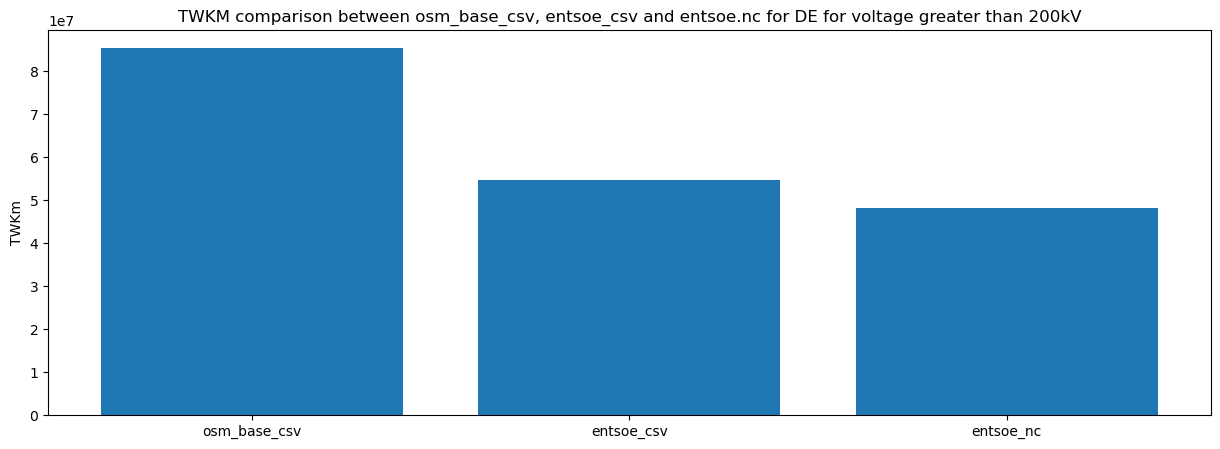

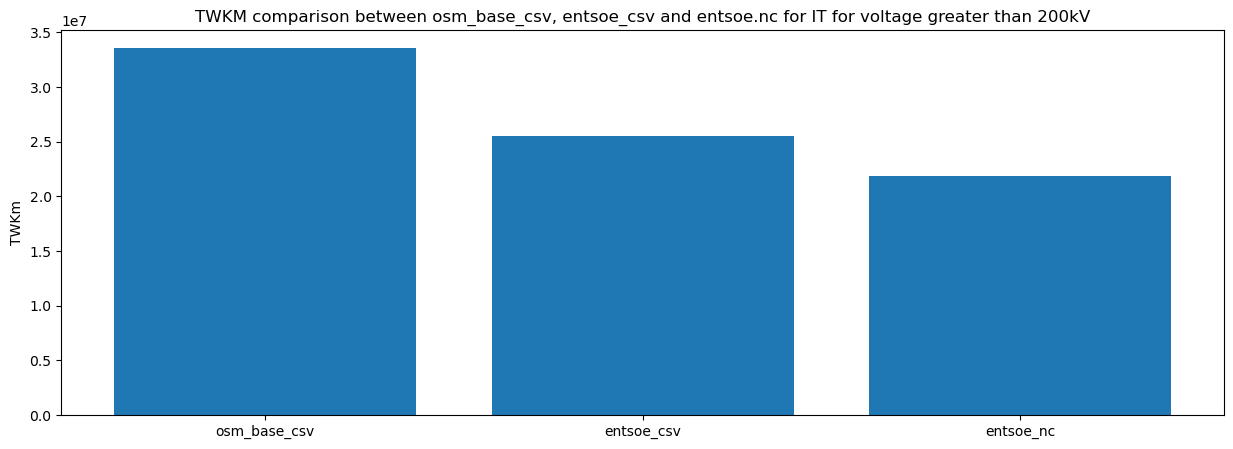

In [26]:
# Plot comparison for line capacity between osm_base_csv, entsoe_csv and entsoe_nc

plt.figure(figsize=(15, 5))
plt.bar(
    ["osm_base_csv", "entsoe_csv", "entsoe_nc"],
    [de_twkm_base_csv, de_twkm_entsoe_csv, de_twkm_entsoe_nc],
)
plt.title(
    f"TWKM comparison between osm_base_csv, entsoe_csv and entsoe.nc for DE for voltage greater than 200kV"
)
plt.ylabel("TWKm")

plt.figure(figsize=(15, 5))
plt.bar(
    ["osm_base_csv", "entsoe_csv", "entsoe_nc"],
    [it_twkm_base_csv, it_twkm_entsoe_csv, it_twkm_entsoe_nc],
)
plt.title(
    f"TWKM comparison between osm_base_csv, entsoe_csv and entsoe.nc for IT for voltage greater than 200kV"
)
plt.ylabel("TWKm")
plt.show()

#### Auxiliary s_nom

Analysis done on s_nom after removing the effect of num_parallel or circuits from s_nom

In [27]:
# Removing the effect of num_parallel from s_nom
entsoe_nc_filtered_de["s_nom_single"] = (
    entsoe_nc_filtered_de["s_nom"] / entsoe_nc_filtered_de["num_parallel"]
)
entsoe_nc_filtered_it["s_nom_single"] = (
    entsoe_nc_filtered_it["s_nom"] / entsoe_nc_filtered_it["num_parallel"]
)

In [28]:
# Removing the effect of circuits from s_nom
de_base_csv_s_nom["s_nom_single"] = (
    de_base_csv_s_nom["s_nom"] / de_base_csv_s_nom["circuits"]
)
it_base_csv_s_nom["s_nom_single"] = (
    it_base_csv_s_nom["s_nom"] / it_base_csv_s_nom["circuits"]
)

In [29]:
# Removing the effect of circuits from s_nom
entsoe_s_nom["s_nom_single"] = entsoe_s_nom.apply(
    lambda row: row["s_nom"] / row["circuits"], axis=1
)

In [30]:
de_base_csv_s_nom.groupby(["voltage"])[["s_nom"]].mean()

,s_nom
voltage,
60000,329.995649
63000,656.897589
65000,668.069317
110000,1084.063977
150000,670.303663
155000,692.647118
220000,3091.328058
225000,3016.366481
300000,1340.607325


voltage,60000,63000,65000,110000,150000,155000,220000,225000,300000,320000,380000,400000,525000,600000
s_nom_single,268.121465,281.527538,290.464920,491.556019,670.303663,692.647118,983.112038,1005.455494,1340.607325,1429.981147,1698.102612,1787.476433,2346.062819,2681.21465
s_nom,329.995649,656.897589,668.069317,1084.063977,670.303663,692.647118,3091.328058,3016.366481,1340.607325,2451.396252,5515.227978,893.738217,2346.062819,2681.21465


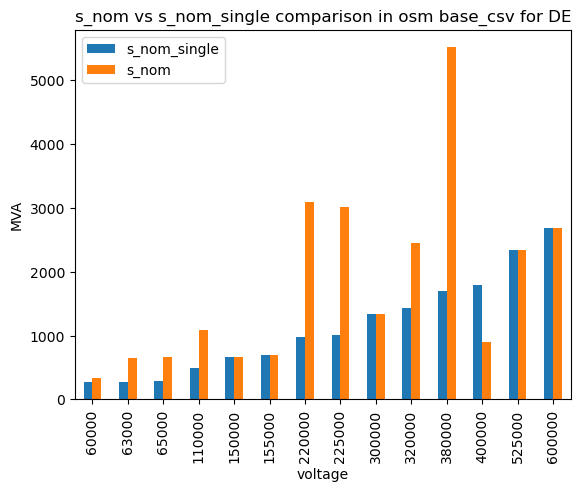

In [31]:
# Table comparing auxiliary s_nom with s_nom in base_csv for DE
s_nom_single_base_s_nom_de = (
    de_base_csv_s_nom.groupby(["voltage"])[["s_nom_single"]]
    .mean()
    .merge(
        de_base_csv_s_nom.groupby(["voltage"])[["s_nom"]].mean(),
        left_on="voltage",
        right_on="voltage",
    )
)

s_nom_single_base_s_nom_de.plot(kind="bar", subplots=False)
plt.ylabel("MVA")
plt.title("s_nom vs s_nom_single comparison in osm base_csv for DE")

s_nom_single_base_s_nom_de.T

voltage,220000,380000
s_nom_single,983.112038,1698.102612
s_nom,1907.129911,3667.608233


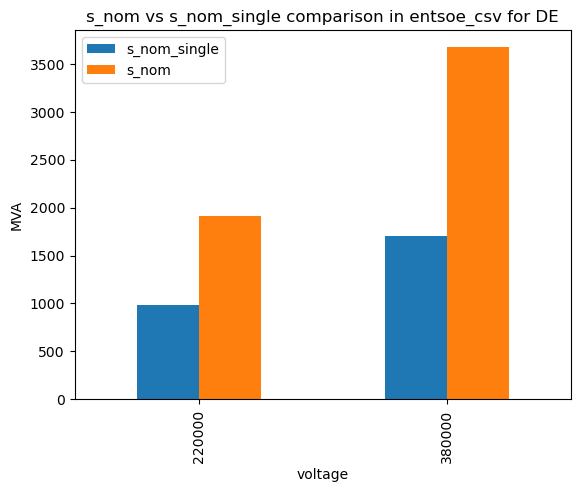

In [32]:
# Table comparing auxiliary s_nom with s_nom in entsoe_csv for DE
s_nom_single_entsoe_s_nom_de = (
    entsoe_s_nom[entsoe_s_nom[f"if_de"] == True]
    .groupby(["voltage"])[["s_nom_single"]]
    .mean()
    .merge(
        entsoe_s_nom[entsoe_s_nom[f"if_de"] == True]
        .groupby(["voltage"])[["s_nom"]]
        .mean(),
        left_on="voltage",
        right_on="voltage",
    )
)

s_nom_single_entsoe_s_nom_de.plot(kind="bar", subplots=False)
plt.ylabel("MVA")
plt.title("s_nom vs s_nom_single comparison in entsoe_csv for DE")

s_nom_single_entsoe_s_nom_de.T

voltage,60000,66000,70000,110000,120000,130000,132000,135000,150000,200000,220000,225000,320000,380000,400000,500000
s_nom_single,268.121465,294.933612,312.808376,491.556019,536.242930,580.929841,589.867223,603.273296,670.303663,893.738217,983.112038,1005.455494,1429.981147,1698.102612,1787.476433,2234.345542
s_nom,287.671989,294.933612,312.808376,491.556019,643.491516,580.929841,660.224880,603.273296,727.832135,1340.607325,1348.324342,1005.455494,2859.962293,2023.271197,1787.476433,2234.345542


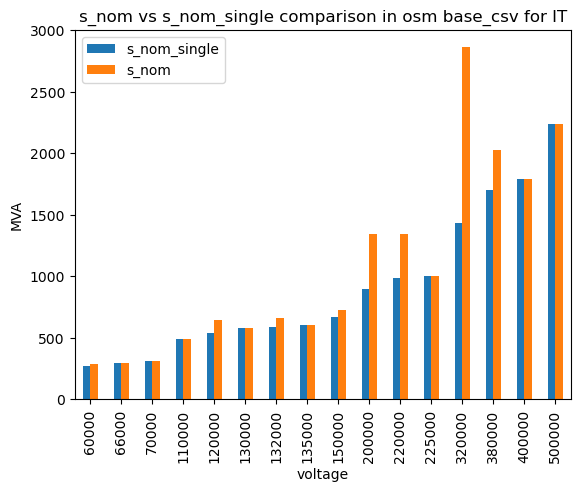

In [33]:
# Table comparing auxiliary s_nom with s_nom in base_csv for IT
s_nom_single_base_s_nom_it = (
    it_base_csv_s_nom.groupby(["voltage"])[["s_nom_single"]]
    .mean()
    .merge(
        it_base_csv_s_nom.groupby(["voltage"])[["s_nom"]].mean(),
        left_on="voltage",
        right_on="voltage",
    )
)

s_nom_single_base_s_nom_it.plot(kind="bar", subplots=False)
plt.ylabel("MVA")
plt.title("s_nom vs s_nom_single comparison in osm base_csv for IT")

s_nom_single_base_s_nom_it.T

voltage,220000,380000
s_nom_single,983.112038,1698.102612
s_nom,1228.890048,1928.709139


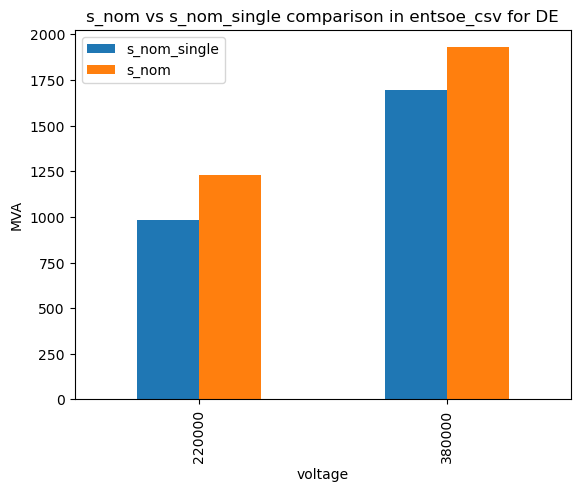

In [34]:
# Table comparing auxiliary s_nom with s_nom in entsoe_csv for IT
s_nom_single_entsoe_s_nom_it = (
    entsoe_s_nom[entsoe_s_nom[f"if_it"] == True]
    .groupby(["voltage"])[["s_nom_single"]]
    .mean()
    .merge(
        entsoe_s_nom[entsoe_s_nom[f"if_it"] == True]
        .groupby(["voltage"])[["s_nom"]]
        .mean(),
        left_on="voltage",
        right_on="voltage",
    )
)

s_nom_single_entsoe_s_nom_it.plot(kind="bar", subplots=False)
plt.ylabel("MVA")
plt.title("s_nom vs s_nom_single comparison in entsoe_csv for DE")

s_nom_single_entsoe_s_nom_it.T

### Comparison between base_nc and base_csv using updated threshold

The analysis performed here is done with another version of pypsa-earth runs with increased voltage threshold (210kV)

In [35]:
# Download and extract the updated version of the data from the google drive link below. The extracted will be placed into "pypsa-earth-networks v2"
# https://drive.google.com/drive/folders/17Gdwe15yRk2nptCtM-Xm06AJcFRmM-_x?usp=drive_link

In [36]:
# Load the updated osm_base network
base_nc_v2 = pypsa.Network("pypsa-earth-networks v2/networks/base.nc")

INFO:pypsa.io:Imported network base.nc has buses, lines, links, transformers


In [37]:
# Load updated osm_base file
base_csv_v2 = pd.read_csv(
    "pypsa-earth-networks v2/resources/base_network/all_lines_build_network.csv"
)
base_csv_v2["geometry"] = base_csv_v2.geometry.apply(wkt.loads)
base_csv_v2 = gpd.GeoDataFrame(base_csv_v2, geometry="geometry", crs="EPSG:4326")
base_csv_v2["reprojected_length"] = base_csv_v2.to_crs("EPSG:3035").length
base_csv_v2_snom = calculate_s_nom(base_csv_v2, voltage_dict, base_nc_v2)

#### s_nom analysis with updated threshold

In [38]:
# Summation of s_nom in base_csv
sum_de_base_csv_v2_snom = base_csv_v2_snom[base_csv_v2_snom.country == "DE"].s_nom.sum()
sum_de_base_nc_v2_snom = base_nc_v2.lines[base_nc_v2.lines.country == "DE"].s_nom.sum()

sum_it_base_csv_v2_snom = base_csv_v2_snom[base_csv_v2_snom.country == "IT"].s_nom.sum()
sum_it_base_nc_v2_snom = base_nc_v2.lines[base_nc_v2.lines.country == "IT"].s_nom.sum()

Confirming the threshold of the voltage values in base_csv which is set to 210kV.

In [39]:
base_csv_v2_snom[base_csv_v2_snom.country == "DE"].voltage.value_counts()

voltage
380000    704
220000    460
400000     23
225000     23
320000     11
525000      3
450000      2
600000      2
300000      1
Name: count, dtype: int64

In [40]:
base_csv_v2_snom[base_csv_v2_snom.country == "IT"].voltage.value_counts()

voltage
220000    361
380000    293
500000      6
400000      3
320000      2
Name: count, dtype: int64

In [41]:
base_nc_v2.lines[base_nc_v2.lines.country == "DE"].v_nom.value_counts()

v_nom
380.0    724
220.0    483
Name: count, dtype: int64

In [42]:
base_nc_v2.lines[base_nc_v2.lines.country == "IT"].v_nom.value_counts()

v_nom
220.0    361
380.0    295
Name: count, dtype: int64

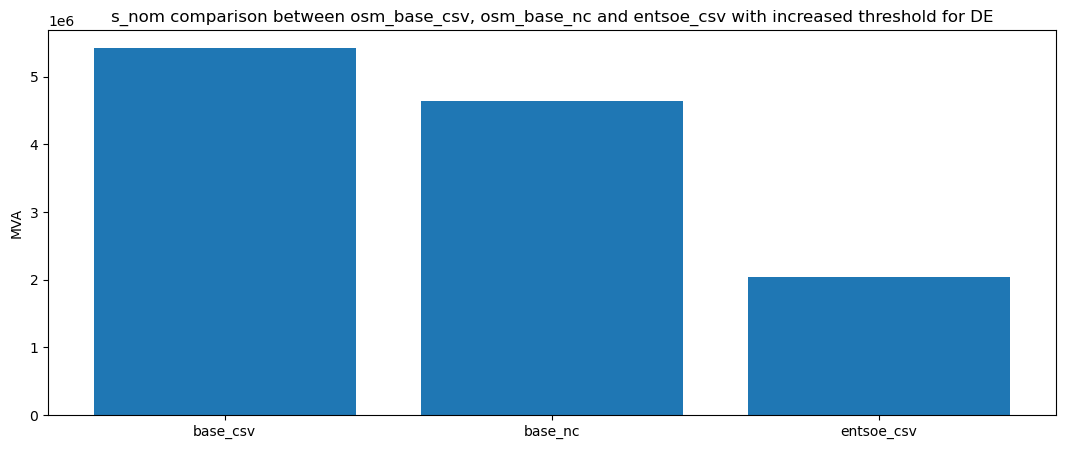

In [43]:
plt.figure(figsize=(13, 5))
plt.bar(
    ["base_csv", "base_nc", "entsoe_csv"],
    [sum_de_base_csv_v2_snom, sum_de_base_nc_v2_snom, sum_de_entsoe_snom],
)
plt.title(
    f"s_nom comparison between osm_base_csv, osm_base_nc and entsoe_csv with increased threshold for DE"
)
plt.ylabel("MVA")
plt.show()

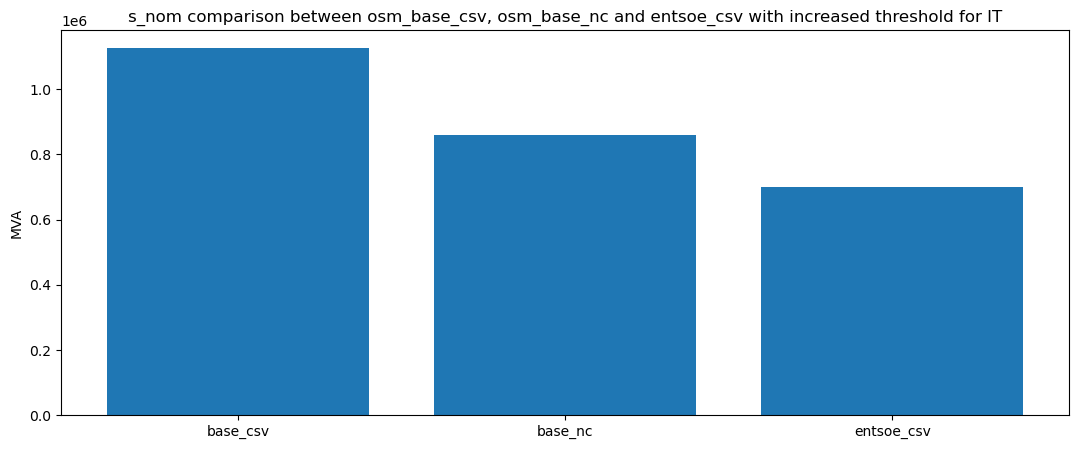

In [44]:
plt.figure(figsize=(13, 5))
plt.bar(
    ["base_csv", "base_nc", "entsoe_csv"],
    [sum_it_base_csv_v2_snom, sum_it_base_nc_v2_snom, sum_it_entsoe_snom],
)
plt.title(
    f"s_nom comparison between osm_base_csv, osm_base_nc and entsoe_csv with increased threshold for IT"
)
plt.ylabel("MVA")
plt.show()

#### TWKm analysis with updated threshold

In [45]:
# Set voltage filtering threshold in V
voltage_threshold_v2 = 200000

In [46]:
# Voltage levels in updated base_csv
print("voltage levels for DE")
print(base_csv_v2_snom[(base_csv_v2_snom.country == "DE")].voltage.value_counts())
print("___________________________________________________________")
print("voltage levels for IT")
print(base_csv_v2_snom[(base_csv_v2_snom.country == "IT")].voltage.value_counts())

voltage levels for DE
voltage
380000    704
220000    460
400000     23
225000     23
320000     11
525000      3
450000      2
600000      2
300000      1
Name: count, dtype: int64
___________________________________________________________
voltage levels for IT
voltage
220000    361
380000    293
500000      6
400000      3
320000      2
Name: count, dtype: int64


The voltages in the updated osm_base_csv does not go below 200kV

In [47]:
# Total sum of line capacity in base_csv for lines above the set threshold
de_base_csv_s_nom_v2 = base_csv_v2_snom[
    (base_csv_v2_snom.country == "DE")
    & (base_csv_v2_snom.voltage > voltage_threshold_v2)
]
de_twkm_base_csv_v2 = (
    de_base_csv_s_nom_v2.s_nom * de_base_csv_s_nom_v2.reprojected_length
).sum() / 1e3

it_base_csv_s_nom_v2 = base_csv_v2_snom[
    (base_csv_v2_snom.country == "IT")
    & (base_csv_v2_snom.voltage > voltage_threshold_v2)
]
it_twkm_base_csv_v2 = (
    it_base_csv_s_nom_v2.s_nom * it_base_csv_s_nom_v2.reprojected_length
).sum() / 1e3

In [48]:
# Total sum of line capacity in entsoe_csv
de_entsoe_snom_csv = entsoe_s_nom[entsoe_s_nom[f"if_de"] == True]
de_twkm_entsoe_csv = (
    (de_entsoe_snom_csv["length"] / 1e3) * (de_entsoe_snom_csv["s_nom"])
).sum()

it_entsoe_snom_csv = entsoe_s_nom[entsoe_s_nom[f"if_it"] == True]
it_twkm_entsoe_csv = (
    (it_entsoe_snom_csv["length"] / 1e3) * (it_entsoe_snom_csv["s_nom"])
).sum()

In [49]:
# Total sum of line capacity in entsoe_nc
de_twkm_entsoe_nc = (
    entsoe_nc_filtered_de["length"] * entsoe_nc_filtered_de["s_nom"]
).sum()

it_twkm_entsoe_nc = (
    entsoe_nc_filtered_it["length"] * entsoe_nc_filtered_it["s_nom"]
).sum()

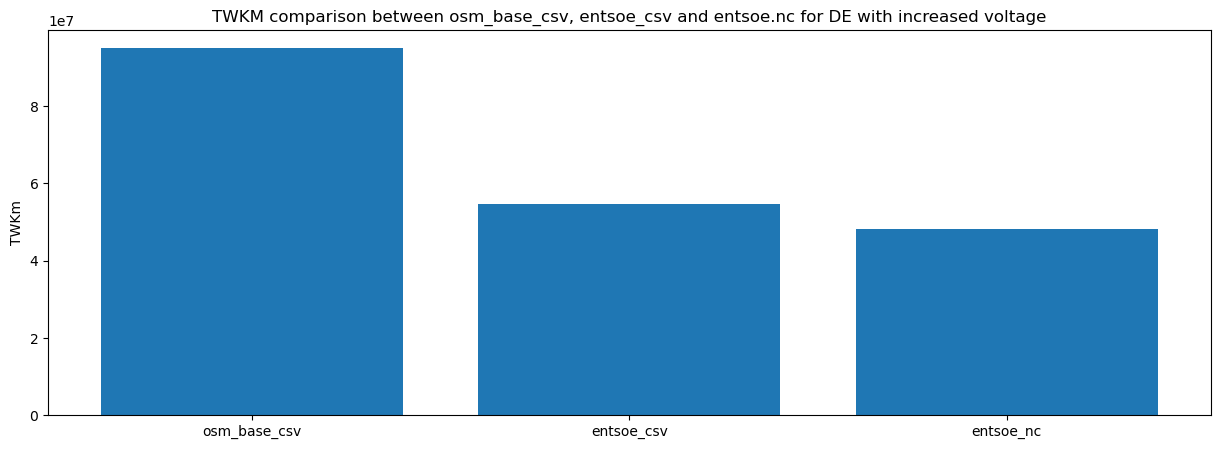

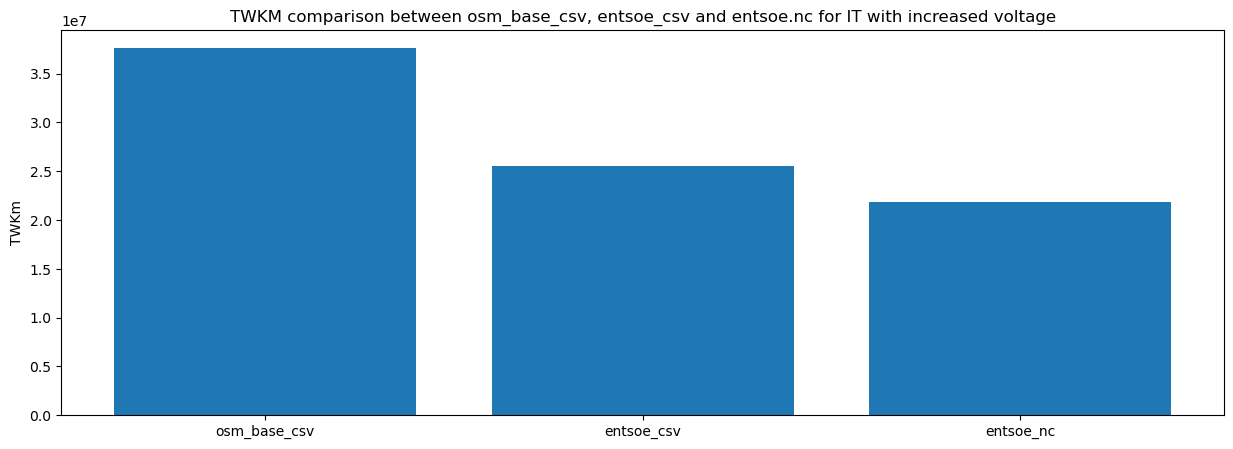

In [50]:
plt.figure(figsize=(15, 5))
plt.bar(
    ["osm_base_csv", "entsoe_csv", "entsoe_nc"],
    [de_twkm_base_csv_v2, de_twkm_entsoe_csv, de_twkm_entsoe_nc],
)
plt.title(
    f"TWKM comparison between osm_base_csv, entsoe_csv and entsoe.nc for DE with increased voltage"
)
plt.ylabel("TWKm")

plt.figure(figsize=(15, 5))
plt.bar(
    ["osm_base_csv", "entsoe_csv", "entsoe_nc"],
    [it_twkm_base_csv_v2, it_twkm_entsoe_csv, it_twkm_entsoe_nc],
)
plt.title(
    f"TWKM comparison between osm_base_csv, entsoe_csv and entsoe.nc for IT with increased voltage"
)
plt.ylabel("TWKm")
plt.show()

# Conclusion

This analysis aimed to explore transmission capacity lines, focusing on the discrepancy between OSM-derived data in PyPSA-Earth model and the reference ENTSOE dataset for Italy and Germany. Specifically, `base.nc` has been examined in part of power grid data assumed there.

The quantitative analysis that was carried out in this notebook involved calculation of the Estimated Transmission Network Capacity (TWKm) and Limit of the Apparent Power(s_nom). The analysis included an independent reproducing of PyPSA-Earth workflow to build `base.nc` network model using base -csv's data. As a result, large discrepancies have been detected which prompted further investigation to estimate the sensitivity of the outputs to the threshold voltage values. It has been shown that the observed discrepancy with the 210kV threshold was more than the discrepancy with the 51kV threshold.

The inconsistencies hint at a possible modelling flaws in the current modelling approach using in OSM data neccessitating further investidation and modelling.

